In [1]:
# Import required packages 
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np 
import os 
import pandas as pd 
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

from helpers import ExploratoryAnalysisHelpers as help

In [2]:
# Data set links: 
# Parkinsons Telemonitoring: https://www.kaggle.com/datasets/abdelazizsami/parkinsons-telemonitoring
# Parkinsons Speech Features: https://www.kaggle.com/code/kerneler/starter-parkinson-s-disease-pd-33cbce88-7/input

# Load Speech Features csv file 
data = pd.read_csv('data/pd_speech_features.csv')

In [3]:
## Exploratory Analysis

# Basic information
print("Dataset Shape:", data.shape)
print("\nDataset Info:")
print(data.info())
print("\nDataset Head:")
print(data.head())
print("\nData Types:")
print(data.dtypes)
print("\nMissing Values:")
print(data.isna().sum())
print("\nDuplicate Values:")
print(data.duplicated().sum())

# Descriptive statistics
print("\nDescriptive Statistics:")
print(data.describe())

# Check skewness of the data
data.skew().sort_values(ascending=False)

Dataset Shape: (756, 755)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Columns: 755 entries, id to class
dtypes: float64(749), int64(6)
memory usage: 4.4 MB
None

Dataset Head:
   id  gender      PPE      DFA     RPDE  numPulses  numPeriodsPulses  \
0   0       1  0.85247  0.71826  0.57227        240               239   
1   0       1  0.76686  0.69481  0.53966        234               233   
2   0       1  0.85083  0.67604  0.58982        232               231   
3   1       0  0.41121  0.79672  0.59257        178               177   
4   1       0  0.32790  0.79782  0.53028        236               235   

   meanPeriodPulses  stdDevPeriodPulses  locPctJitter  ...  \
0          0.008064            0.000087       0.00218  ...   
1          0.008258            0.000073       0.00195  ...   
2          0.008340            0.000060       0.00176  ...   
3          0.010858            0.000183       0.00419  ...   
4          0.008162            0

tqwt_TKEO_mean_dec_32            26.482585
tqwt_TKEO_std_dec_32             26.062084
tqwt_TKEO_mean_dec_33            24.944266
tqwt_TKEO_std_dec_33             24.283816
det_TKEO_mean_3_coef             20.874872
                                   ...    
det_LT_entropy_shannon_7_coef   -21.415098
tqwt_medianValue_dec_29         -21.623644
tqwt_skewnessValue_dec_24       -22.684340
tqwt_entropy_shannon_dec_33     -25.061352
tqwt_entropy_shannon_dec_32     -25.672811
Length: 755, dtype: float64

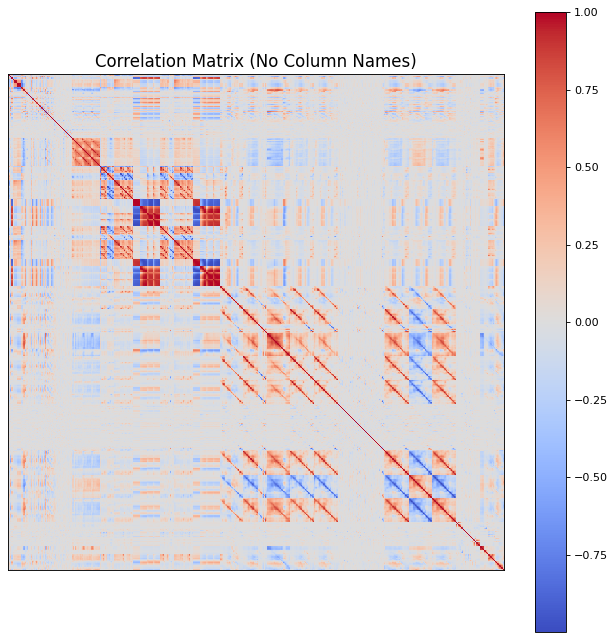

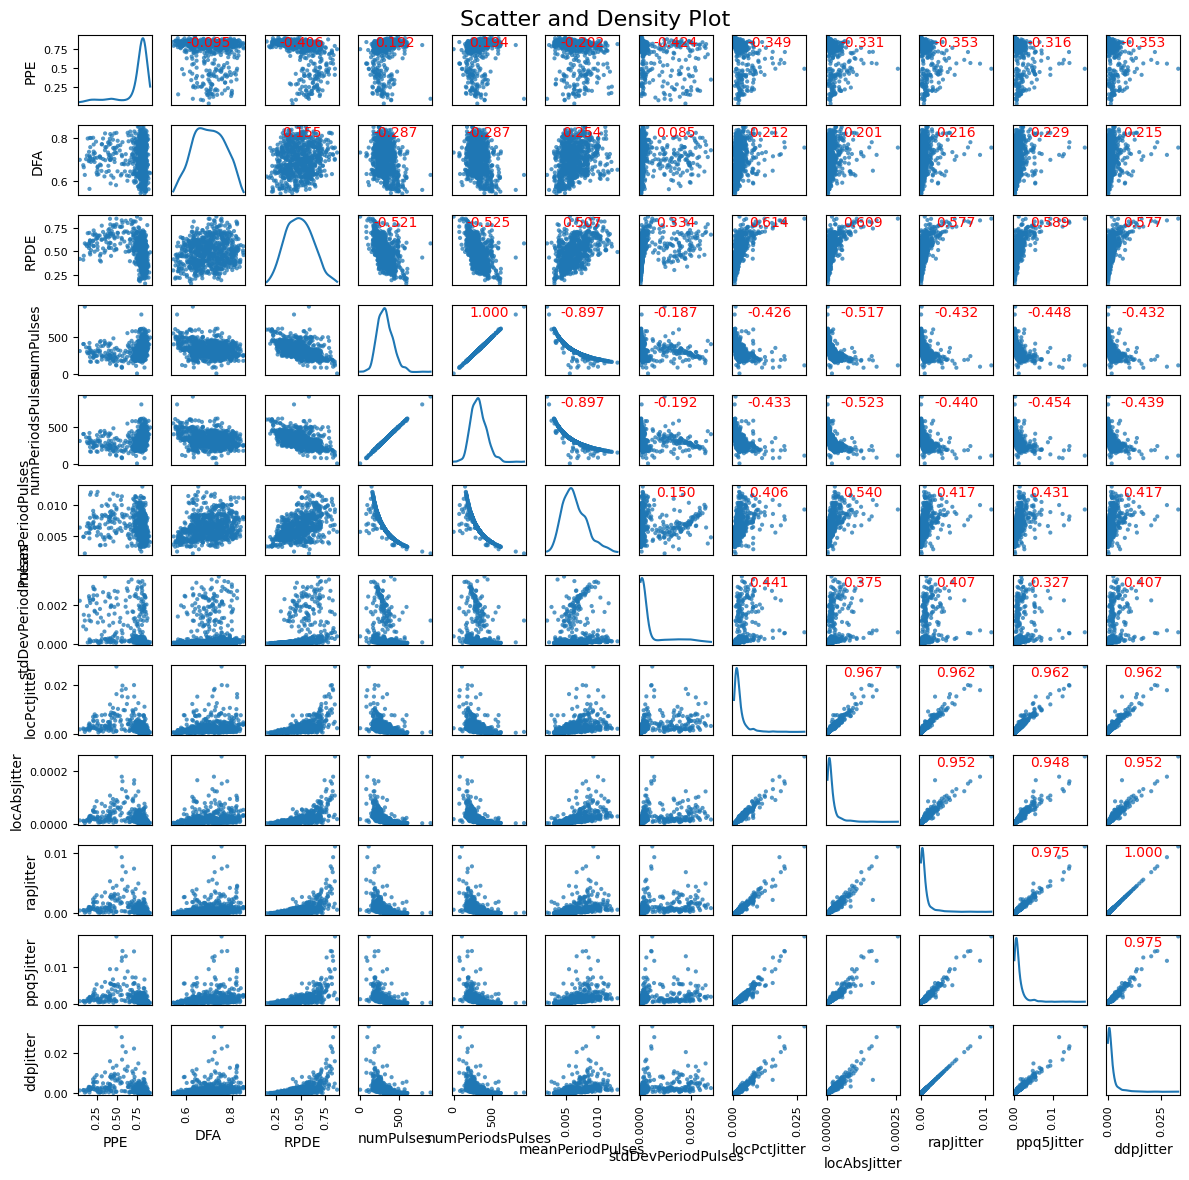

In [4]:
## Exploratory Analysis Continued 

# Enhanced Correlation Matrix
help.plotCorrelationMatrix(data, graphWidth=10)

# Scatter and density plots
help.plotScatterMatrix(data, plotSize=12, textSize=10)


Count of Unique IDs by Gender and Disease Status:
                   Healthy (class=0)  PD (class=1)
Female (gender=0)                 41            81
Male (gender=1)                   23           107


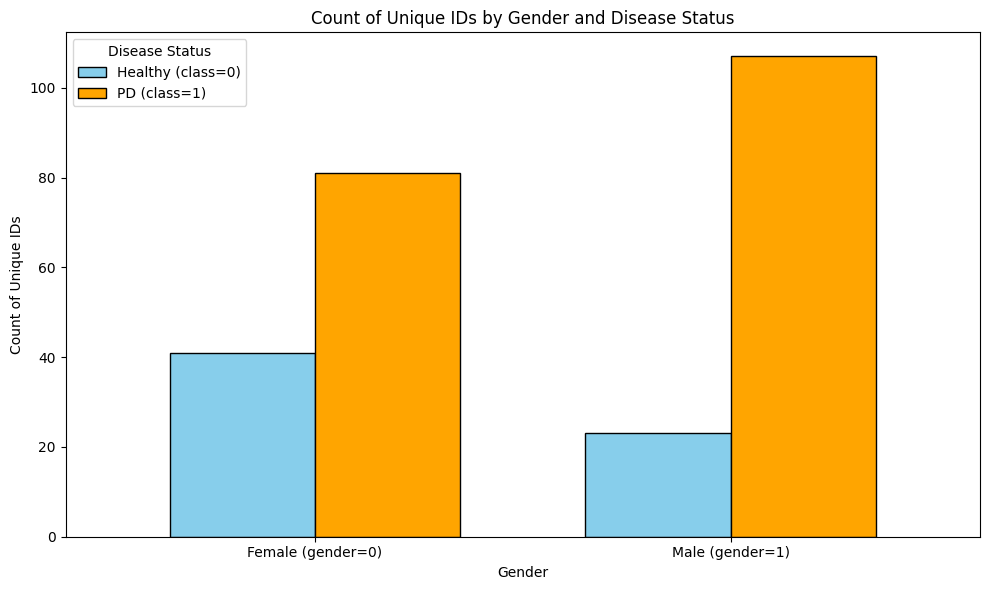


Histograms by Disease Status


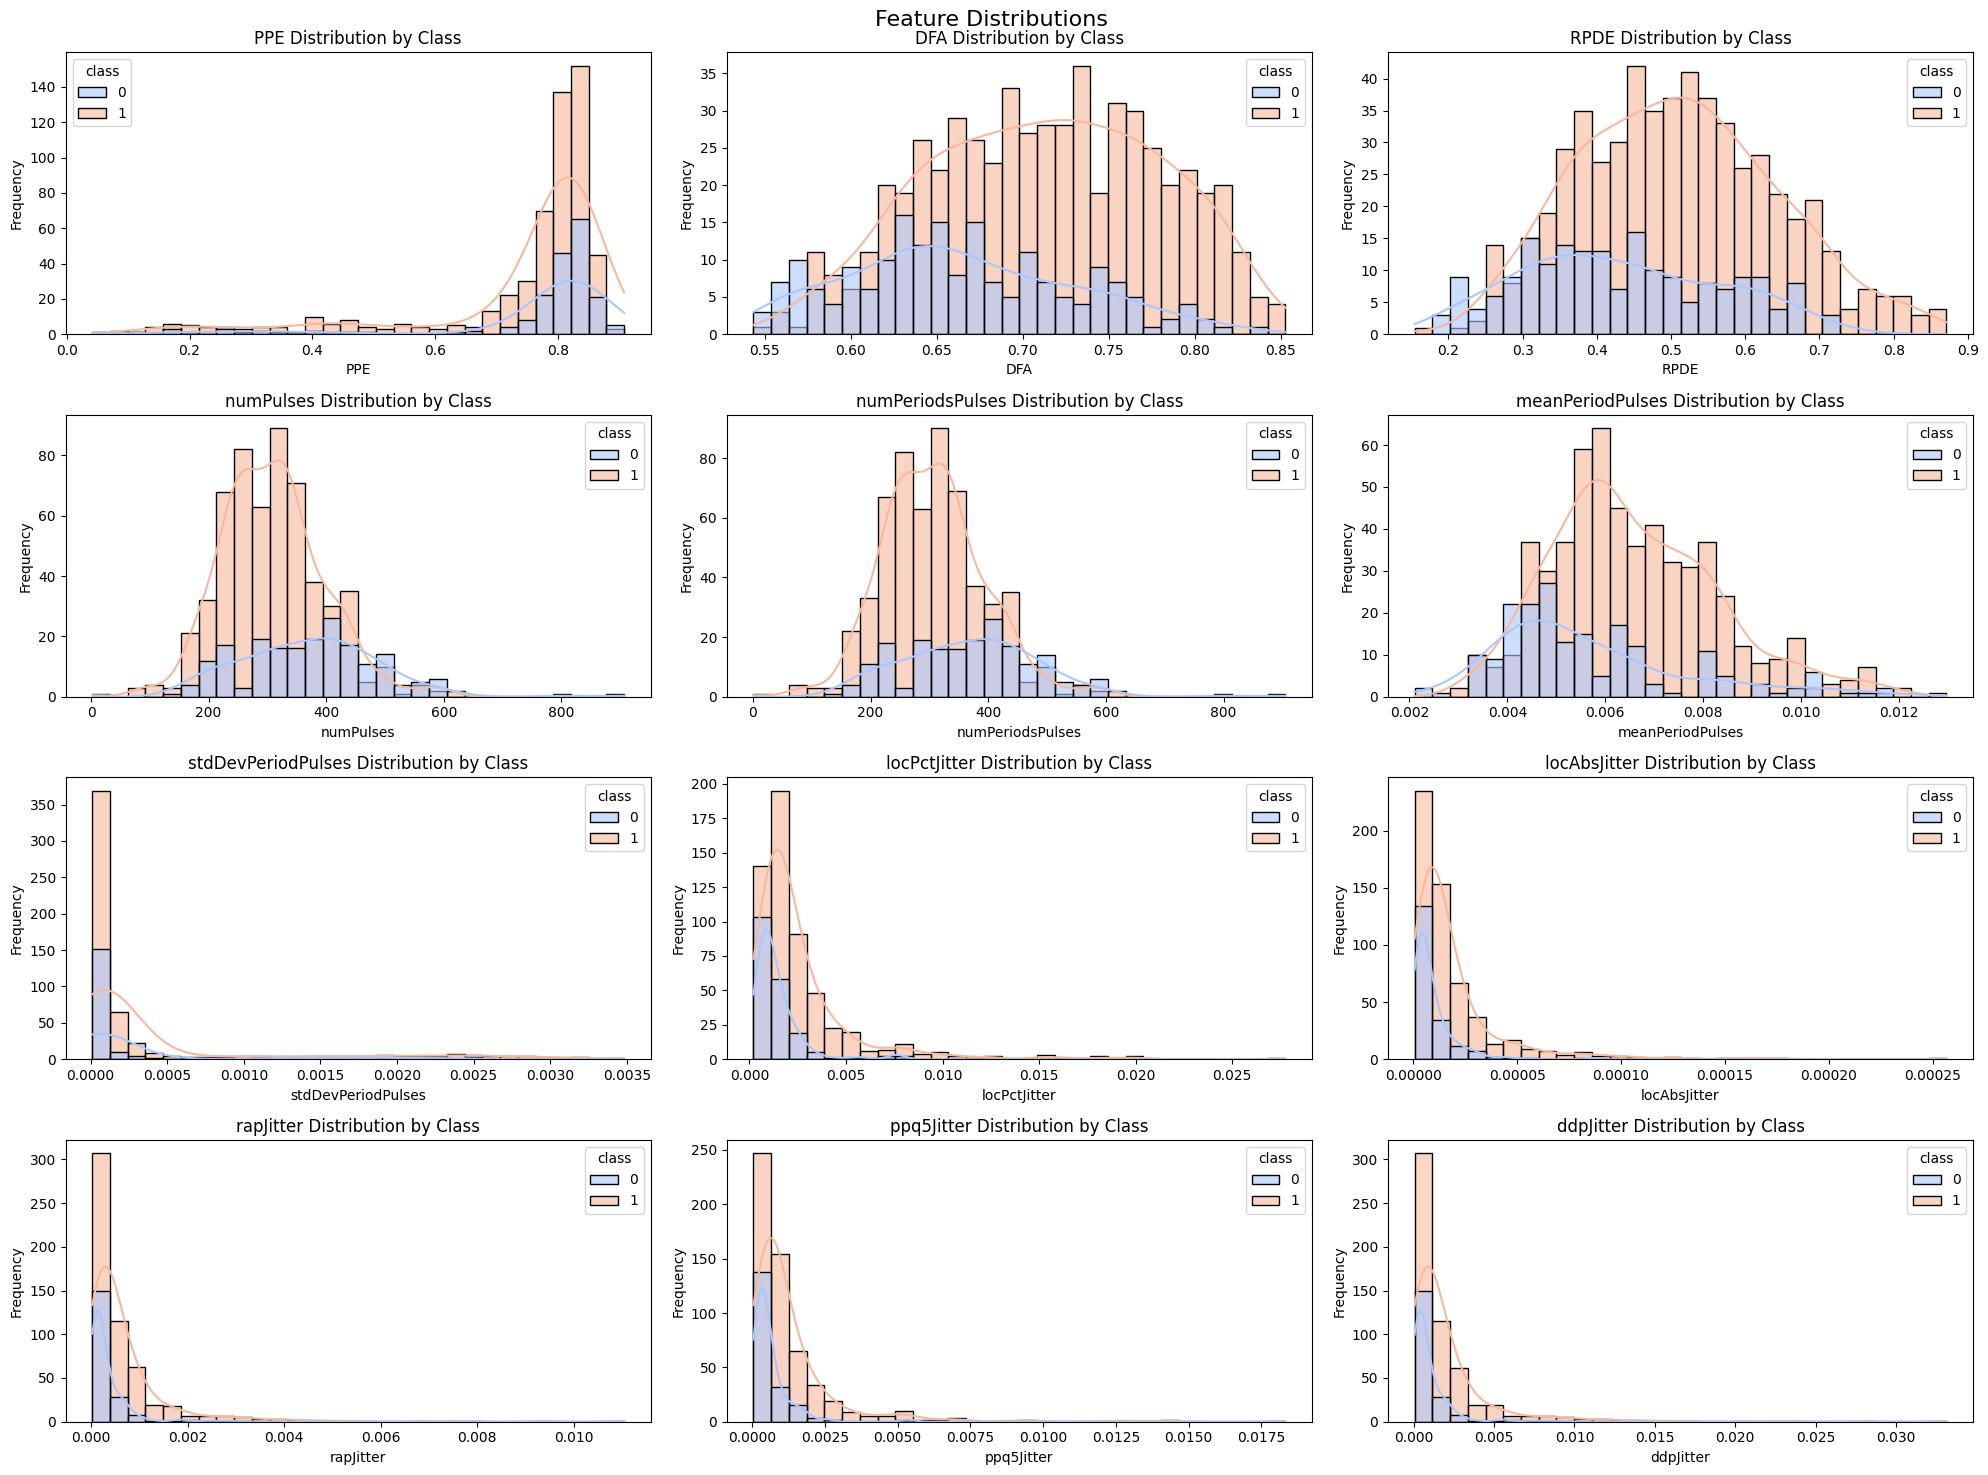

Feature Distributions by Gender and Disease Status


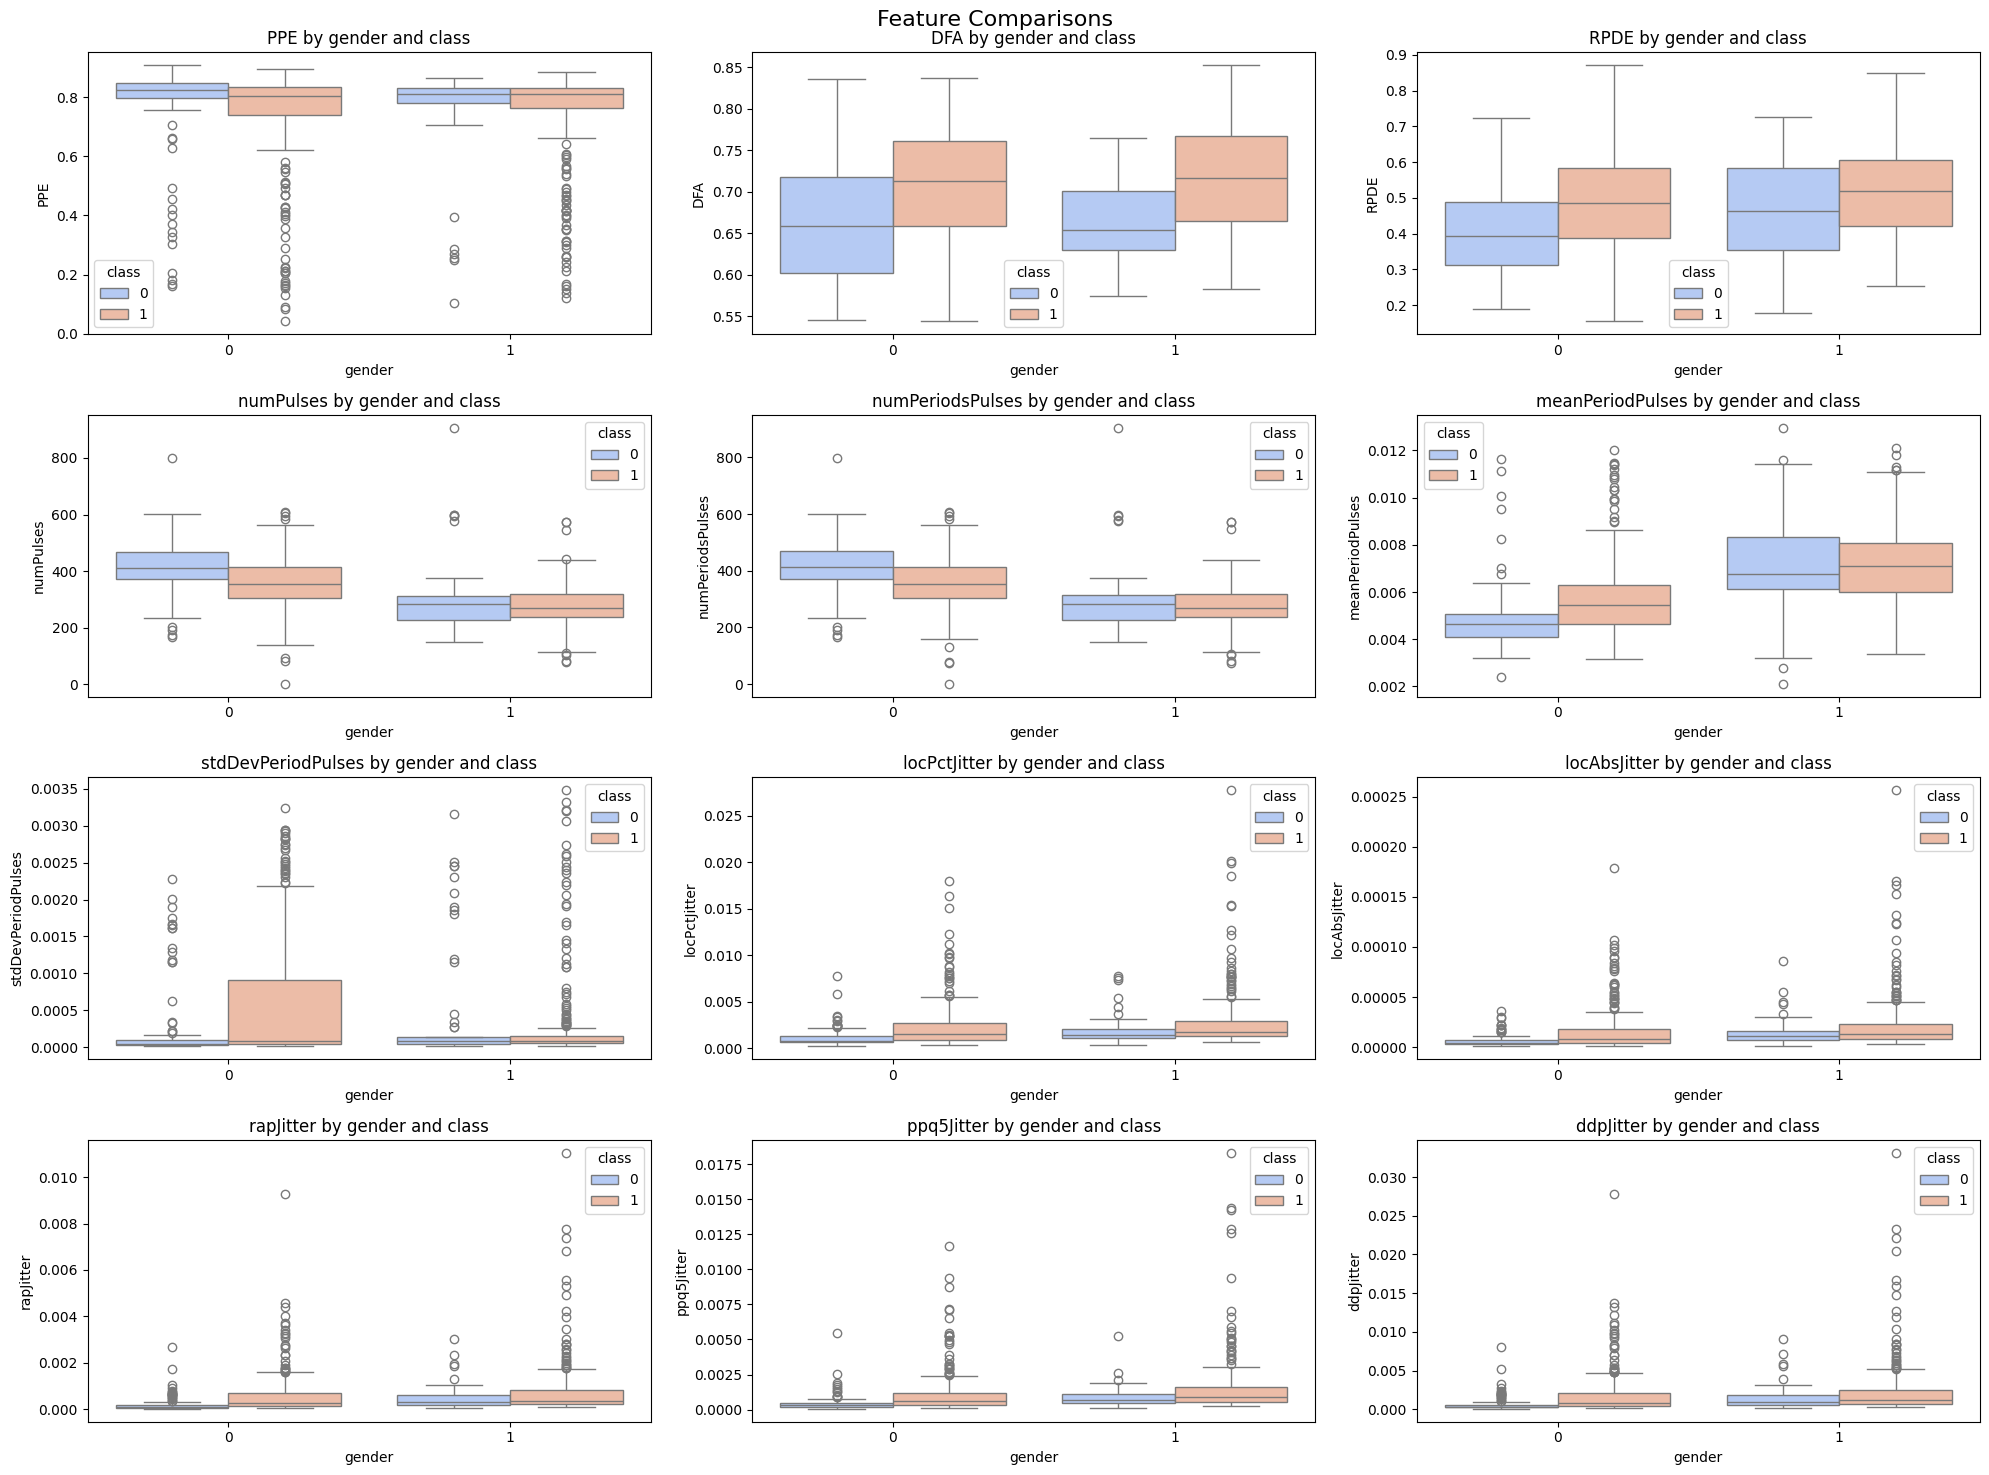

In [6]:
## Exploratory Analysis Continued 

# Gender and PD Status Comparisons 
# Confirm gender binary mapping with data description
unique_ids = data[['id', 'gender', 'class']].drop_duplicates()
    
# Create a pivot table to count IDs based on Gender and Target
summary_table = unique_ids.pivot_table(
    index='gender', 
    columns='class', 
    values='id', 
    aggfunc='count', 
    fill_value=0
)
    
# Rename columns for clarity
summary_table.columns = ['Healthy (class=0)', 'PD (class=1)']
summary_table.index = ['Female (gender=0)', 'Male (gender=1)']
    
print("Count of Unique IDs by Gender and Disease Status:")
print(summary_table) 

# Plot the relationship between gender and PD status 
# Side-by-side bar plot
summary_table.plot(
    kind='bar', 
    figsize=(10, 6), 
    width=0.7, 
    color=['skyblue', 'orange'], 
    edgecolor='black'
)

plt.title('Count of Unique IDs by Gender and Disease Status')
plt.xlabel('Gender')
plt.ylabel('Count of Unique IDs')
plt.xticks(rotation=0)
plt.legend(title='Disease Status')
# plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\nHistograms by Disease Status")

# Feature distributions
help.plotFeatureDistributions(data, title='', targetCol='class')

# Select numeric columns for analysis, dropping ID and low-variance columns
numeric_features = data.select_dtypes(include=['float64', 'int64']).columns
numeric_features = [col for col in numeric_features if data[col].nunique() > 1 and col not in ['id', 'gender']]

# Plot comparisons by Gender and Target
print("Feature Distributions by Gender and Disease Status")
help.plotGroupComparison(data, groupCol='gender', features=numeric_features, targetCol='class')


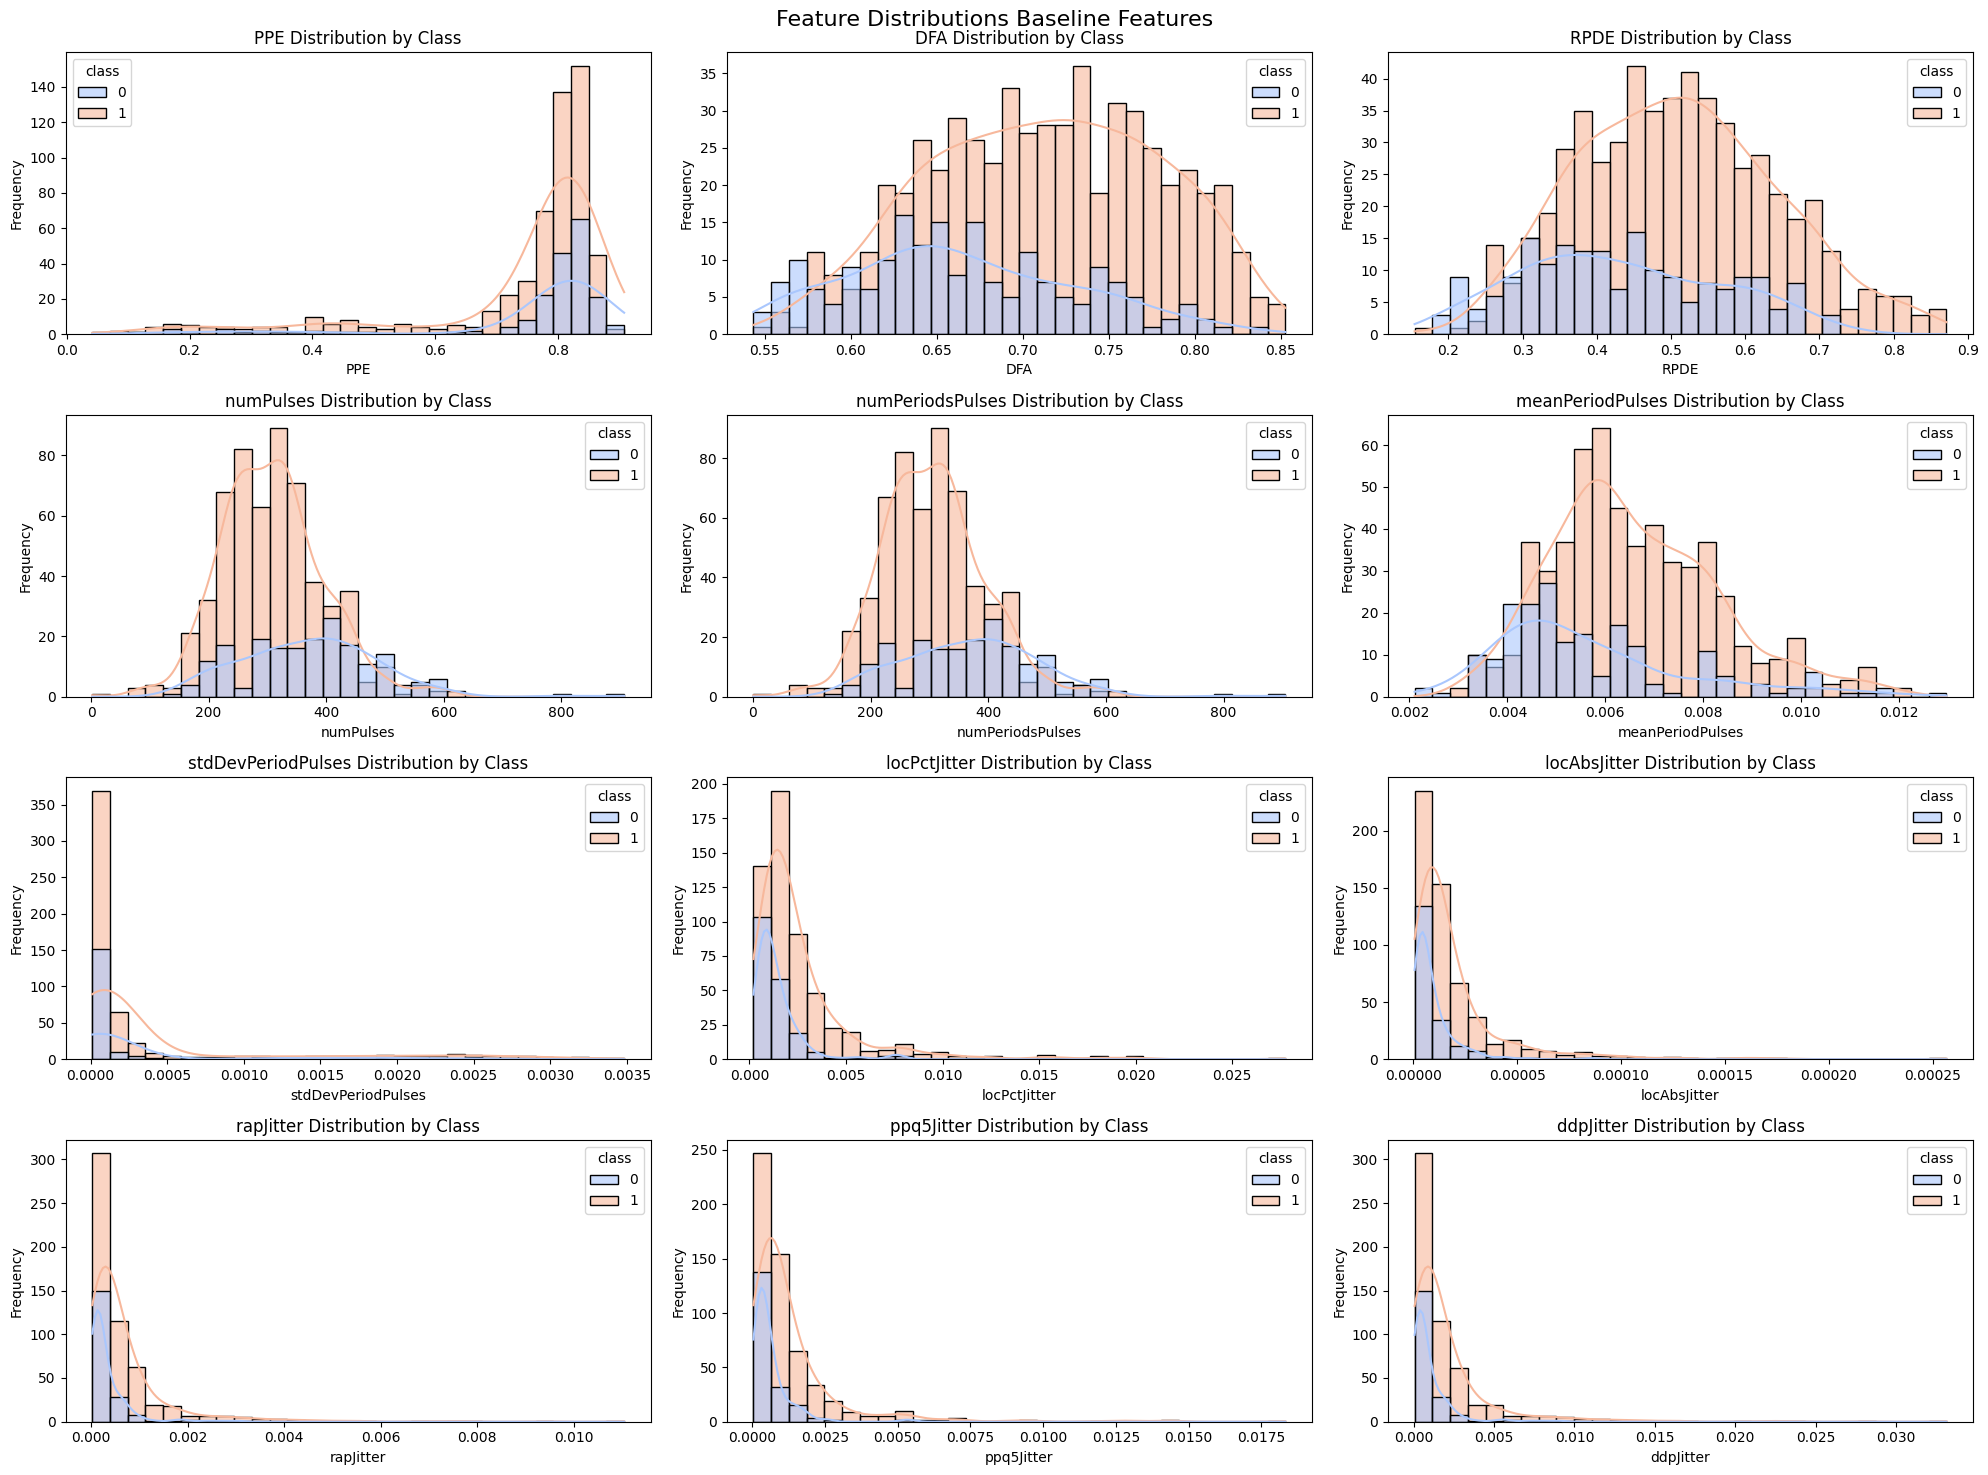

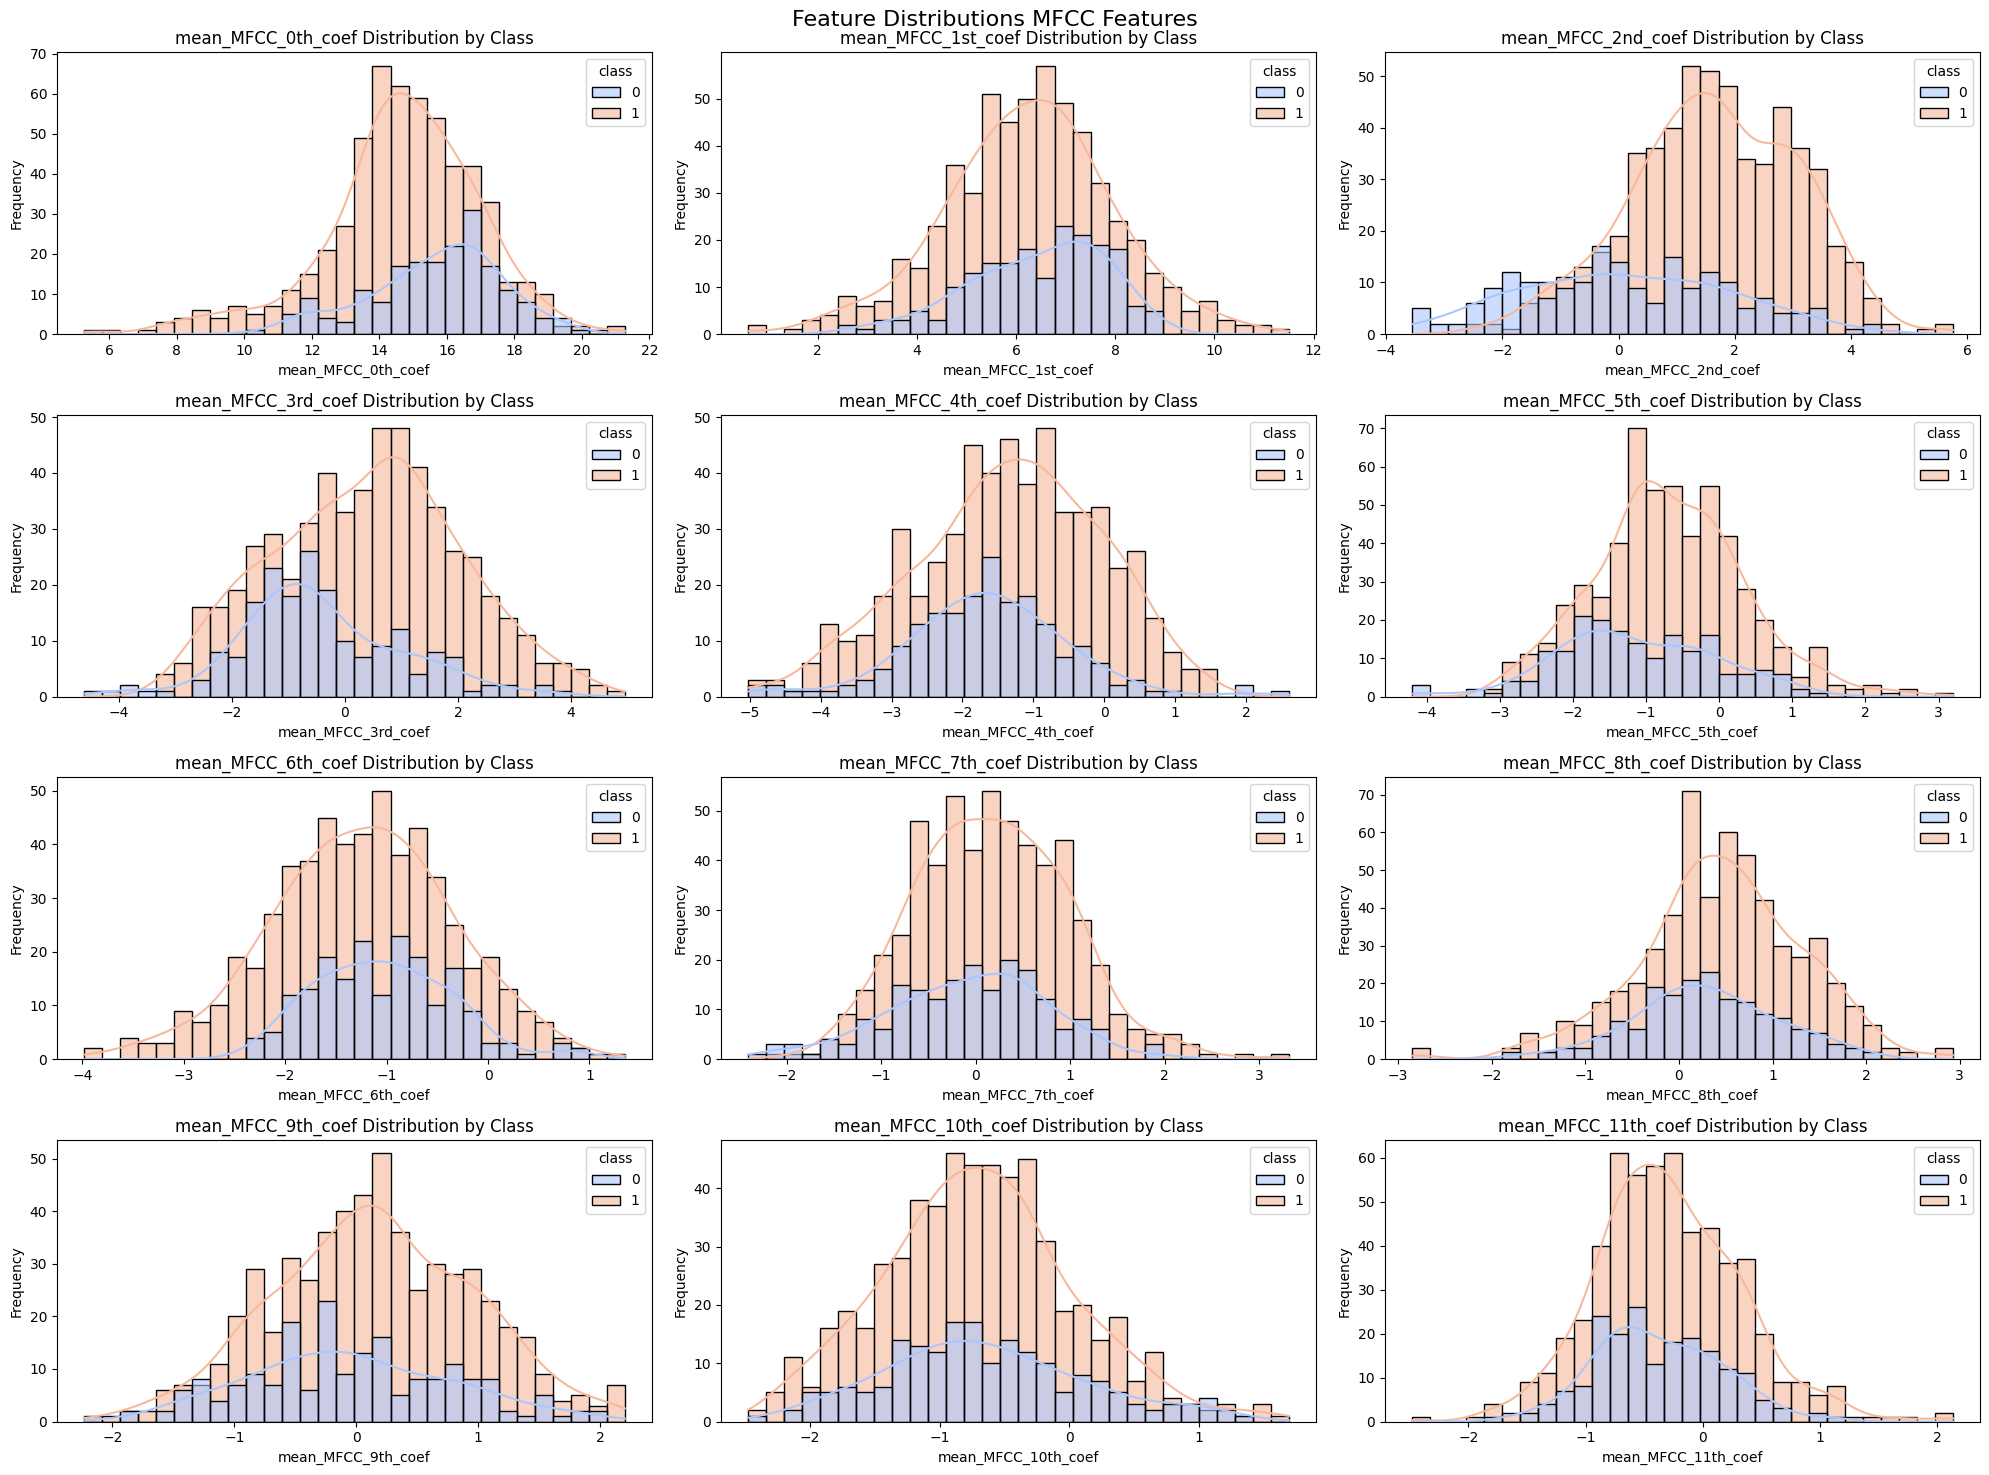

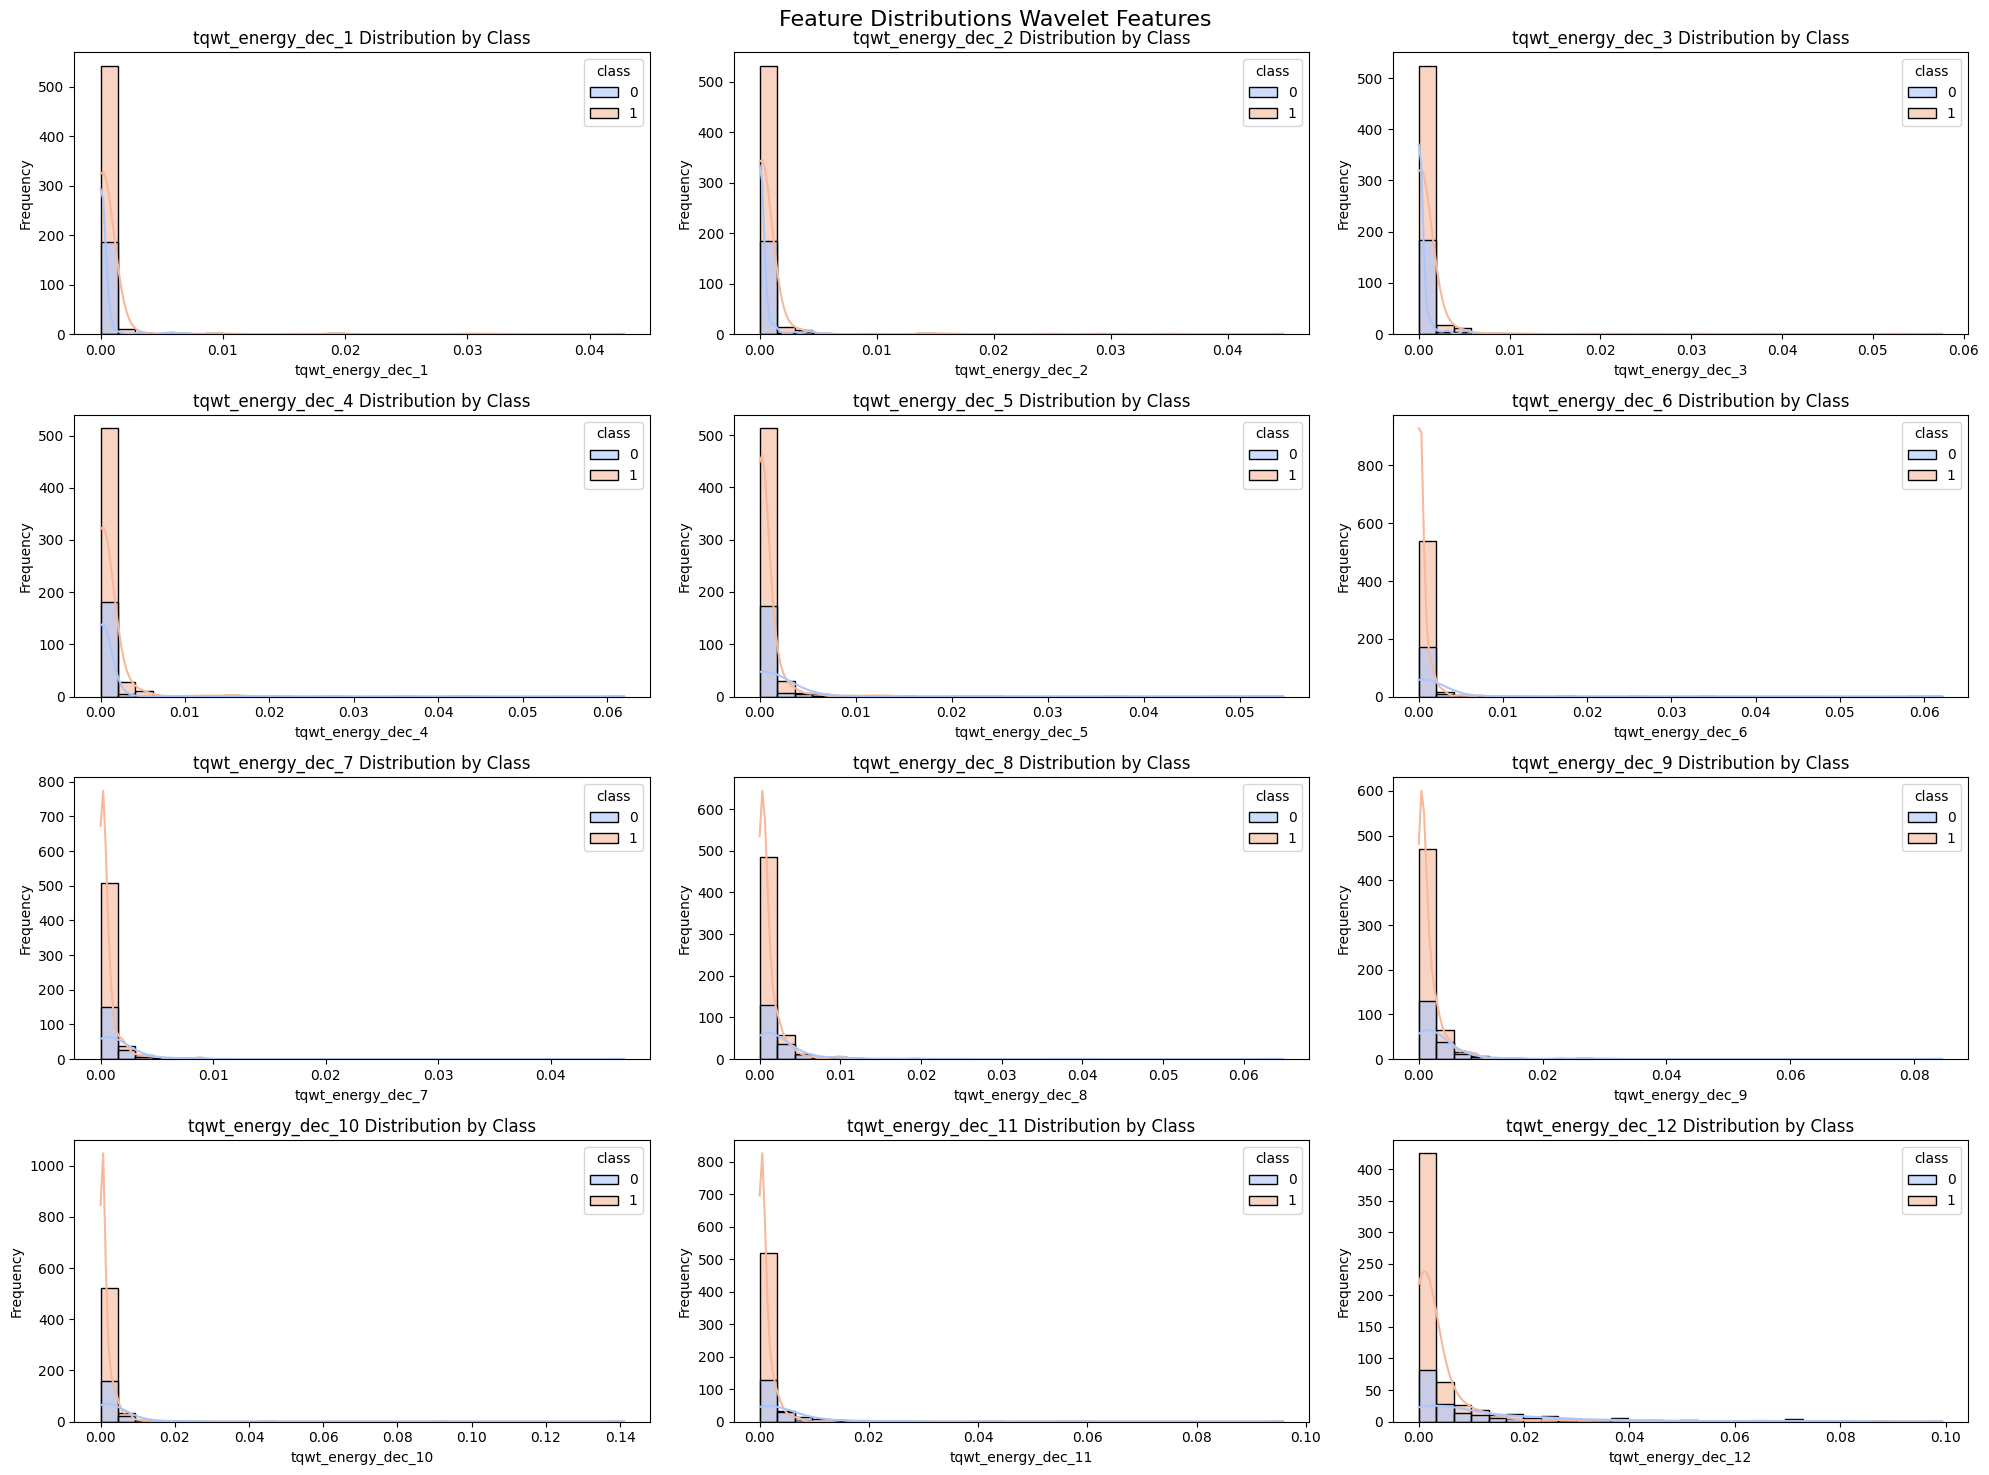

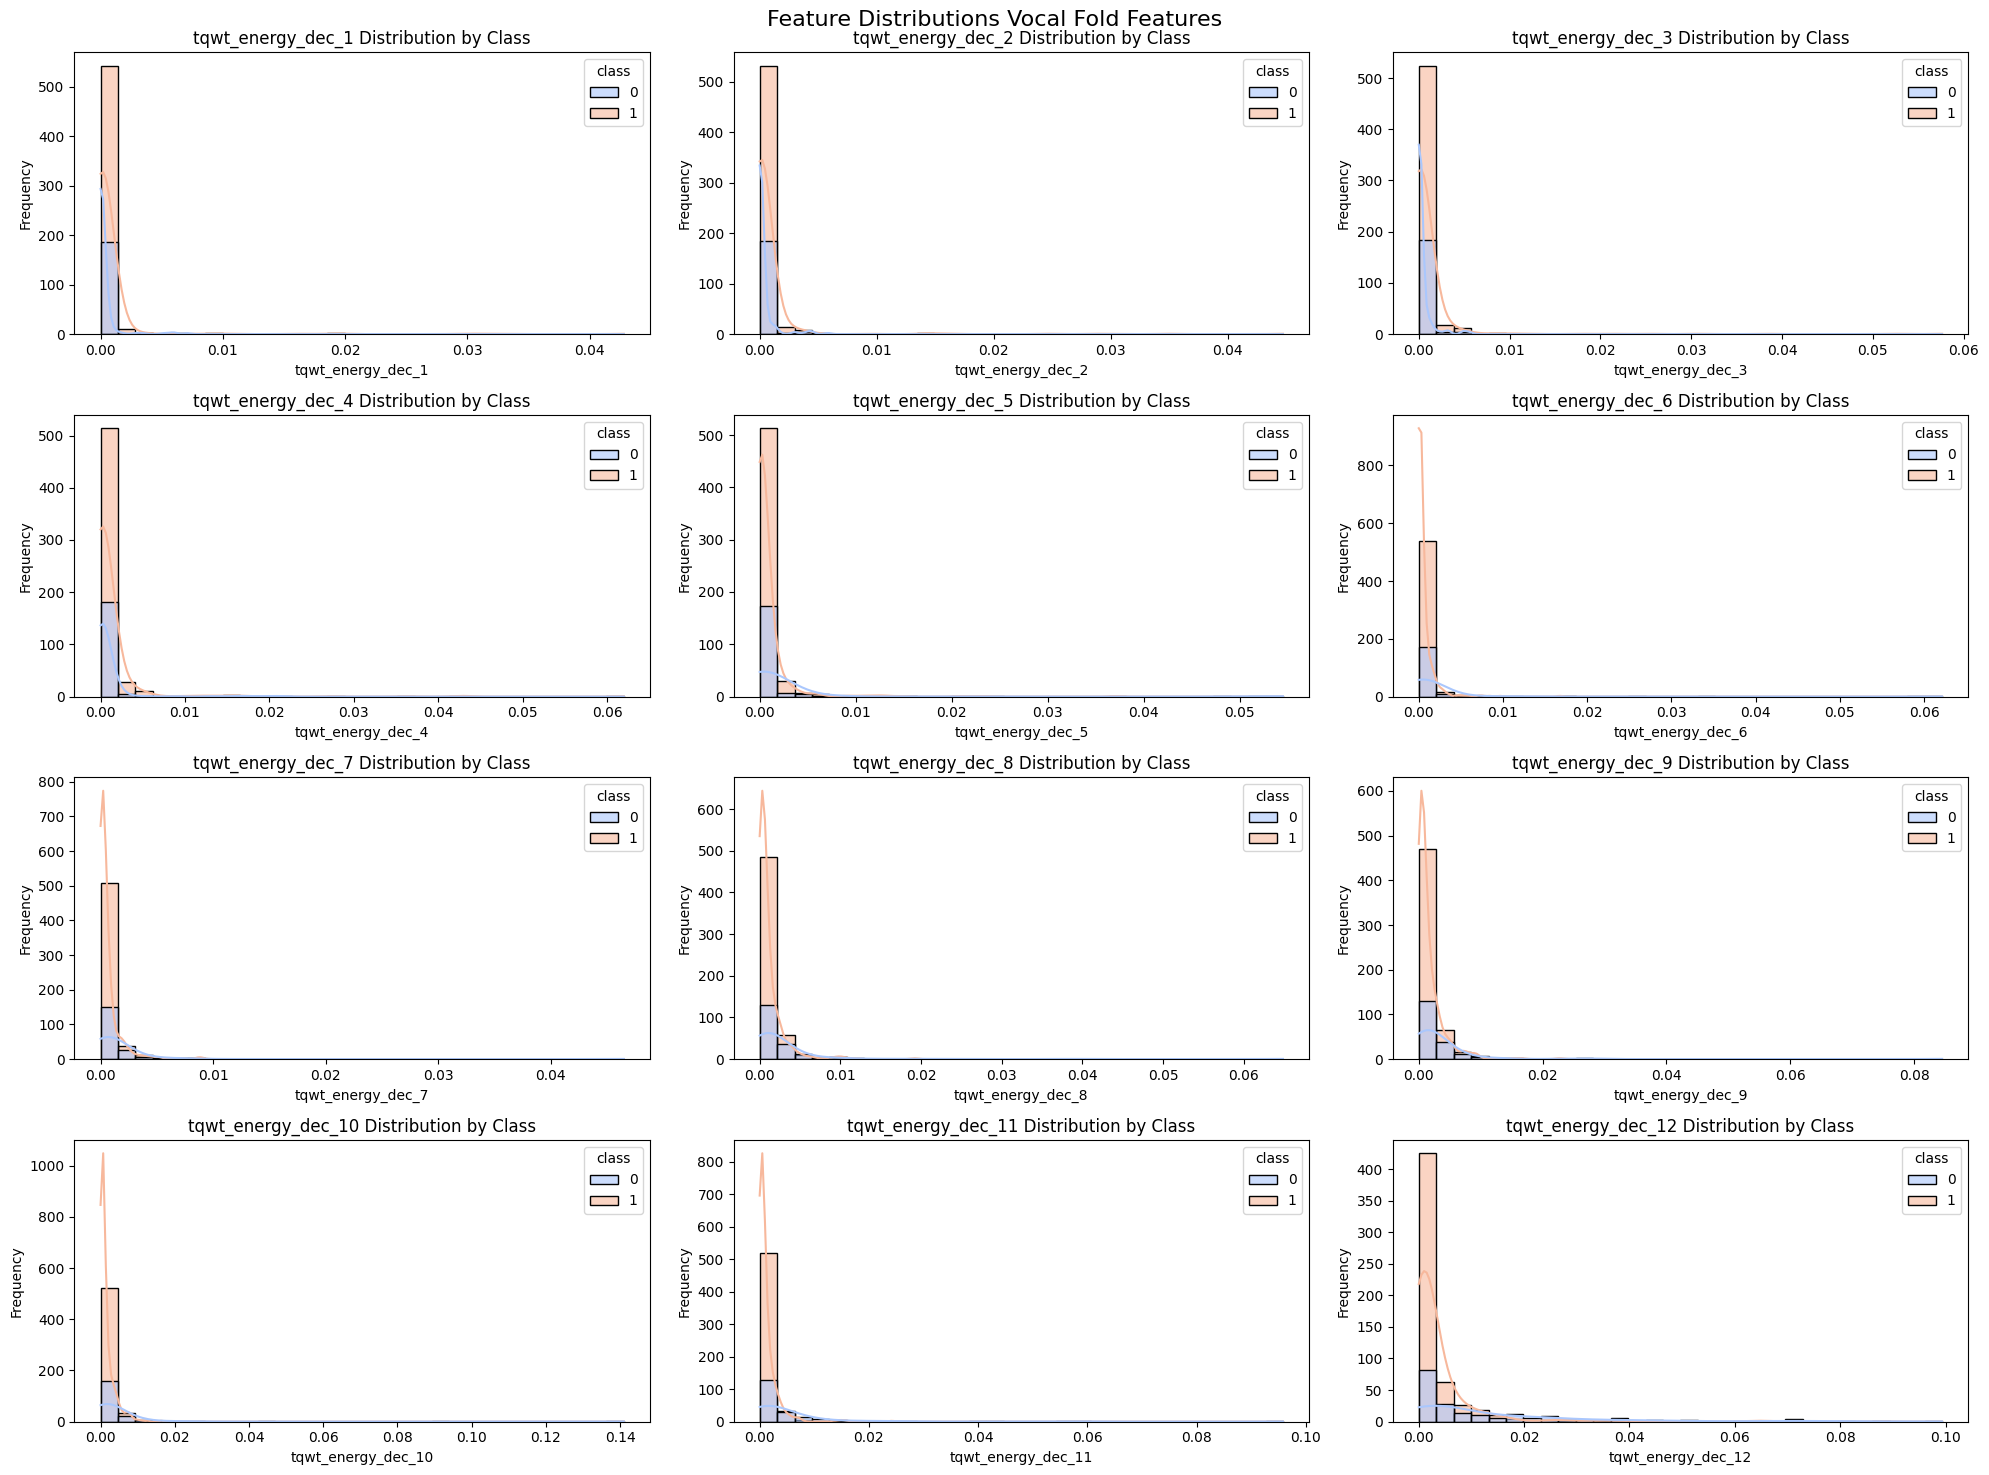

In [8]:

# Define feature subsets
baseline_columns = [
    'PPE', 'DFA', 'RPDE', 'numPulses', 'numPeriodsPulses',
    'meanPeriodPulses', 'stdDevPeriodPulses', 'locPctJitter', 'locAbsJitter',
    'rapJitter', 'ppq5Jitter', 'ddpJitter', 'locShimmer', 'locDbShimmer',
    'apq3Shimmer', 'apq5Shimmer', 'apq11Shimmer', 'ddaShimmer',
    'meanAutoCorrHarmonicity', 'meanNoiseToHarmHarmonicity', 'meanHarmToNoiseHarmonicity'
]

mfcc_columns = [col for col in data.columns if 'MFCC' in col]

wavelet_columns = [
    col for col in data.columns if col.startswith('tqwt_') and '_dec_' in col
]

vocal_fold_columns = [
    col for col in data.columns if any(keyword in col for keyword in [
        'tqwt_energy', 'tqwt_entropy_shannon', 'tqwt_kurtosisValue', 'tqwt_skewnessValue'
    ])
]

# Prepare feature subsets
baseline = data[baseline_columns + ['class']]
mfcc = data[mfcc_columns + ['class']]
wavelet = data[wavelet_columns + ['class']]
vocal_fold = data[vocal_fold_columns + ['class']]

# Feature distributions
help.plotFeatureDistributions(baseline, title='Baseline Features', targetCol='class')
help.plotFeatureDistributions(mfcc, title='MFCC Features', targetCol='class')
help.plotFeatureDistributions(wavelet, title='Wavelet Features', targetCol='class')
help.plotFeatureDistributions(vocal_fold, title='Vocal Fold Features', targetCol='class')



In [ ]:
## Modeling Baseline -- Logistic Regression  

In [ ]:

# Prepare feature subsets
X_baseline = data[baseline_columns]
X_mfcc = data[mfcc_columns]
X_wavelet = data[wavelet_columns]
X_vocal_fold = data[vocal_fold_columns]
y = data['class']

# Define classifiers
classifiers = {
    'Naive Bayes': GaussianNB(),
    'k-NN': KNeighborsClassifier(),
    'Multilayer Perceptron': MLPClassifier(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM (Linear)': SVC(kernel='linear', random_state=42),
    'SVM (RBF)': SVC(kernel='rbf', random_state=42),
    'Logistic Regression (with PCA)': LogisticRegression(max_iter=1000, random_state=42)
}

# Helper function for PCA transformation
def apply_pca(X, variance_threshold=0.95):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    pca = PCA(n_components=variance_threshold)  # Retain components explaining 95% variance
    X_pca = pca.fit_transform(X_scaled)
    return X_pca, pca.explained_variance_ratio_

# Evaluate classifiers on each feature subset
results = {}
feature_subsets = {
    'Baseline': X_baseline,
    'MFCC': X_mfcc,
    'Wavelet': X_wavelet,
    'Vocal Fold': X_vocal_fold
}

for subset_name, X_subset in feature_subsets.items():
    results[subset_name] = {}
    for clf_name, clf in classifiers.items():
        if clf_name == 'Logistic Regression (with PCA)':
            # Apply PCA for Logistic Regression
            X_pca, variance_ratio = apply_pca(X_subset)
            X_to_use = X_pca
        else:
            X_to_use = X_subset
        acc = cross_val_score(clf, X_to_use, y, cv=5, scoring='accuracy').mean()
        f1 = cross_val_score(clf, X_to_use, y, cv=5, scoring='f1').mean()
        results[subset_name][clf_name] = {
            'Accuracy': acc,
            'F1-Score': f1
        }

# Format results into a DataFrame
final_results = []
for subset, clf_results in results.items():
    for clf_name, metrics in clf_results.items():
        final_results.append({
            'Feature Subset': subset,
            'Classifier': clf_name,
            'Accuracy': metrics['Accuracy'],
            'F1-Score': metrics['F1-Score']
        })

# Convert results to DataFrame
results_df = pd.DataFrame(final_results)

# Save the results to a CSV file
results_df.to_csv("classifier_results_with_pca_2.csv", index=False)

print("Results saved to 'classifier_results_with_pca_2.csv'")


In [9]:
gender_groups = data.groupby('gender') 

results = []
for gender, group_data in gender_groups:
    print(f"Processing gender group: {gender}")
    X = group_data.drop(columns=['class', 'gender'])
    y = group_data['class']
    
    for subset_name, columns in feature_subsets.items():
        X_subset = group_data[columns]
        for clf_name, clf in classifiers.items():
            if clf_name == 'Logistic Regression (with PCA)':
                # Apply PCA for Logistic Regression
                X_pca, _ = apply_pca(X_subset)
                X_to_use = X_pca
            else:
                X_to_use = X_subset
            acc = cross_val_score(clf, X_to_use, y, cv=5, scoring='accuracy').mean()
            f1 = cross_val_score(clf, X_to_use, y, cv=5, scoring='f1').mean()
            results.append({
                'Gender': gender,
                'Feature Subset': subset_name,
                'Classifier': clf_name,
                'Accuracy': acc,
                'F1-Score': f1
            })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Save the results to a CSV file
results_df.to_csv("classifier_results_by_gender.csv", index=False)

print("Results saved to 'classifier_results_by_gender.csv'")


Processing gender group: 0


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterat

Processing gender group: 1
Results saved to 'classifier_results_by_gender.csv'


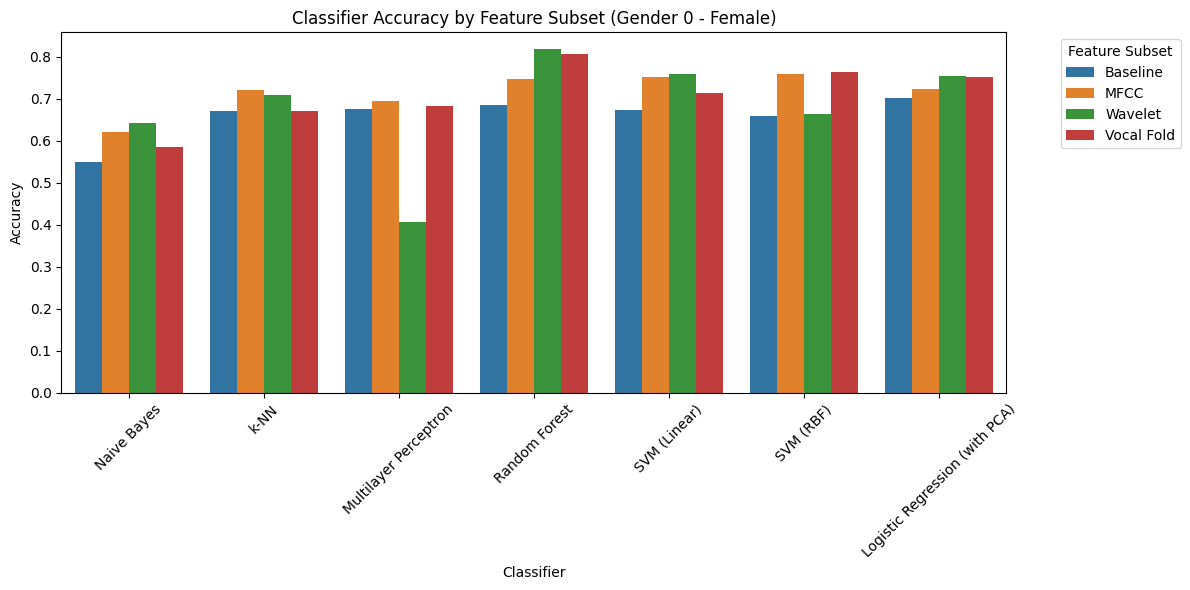

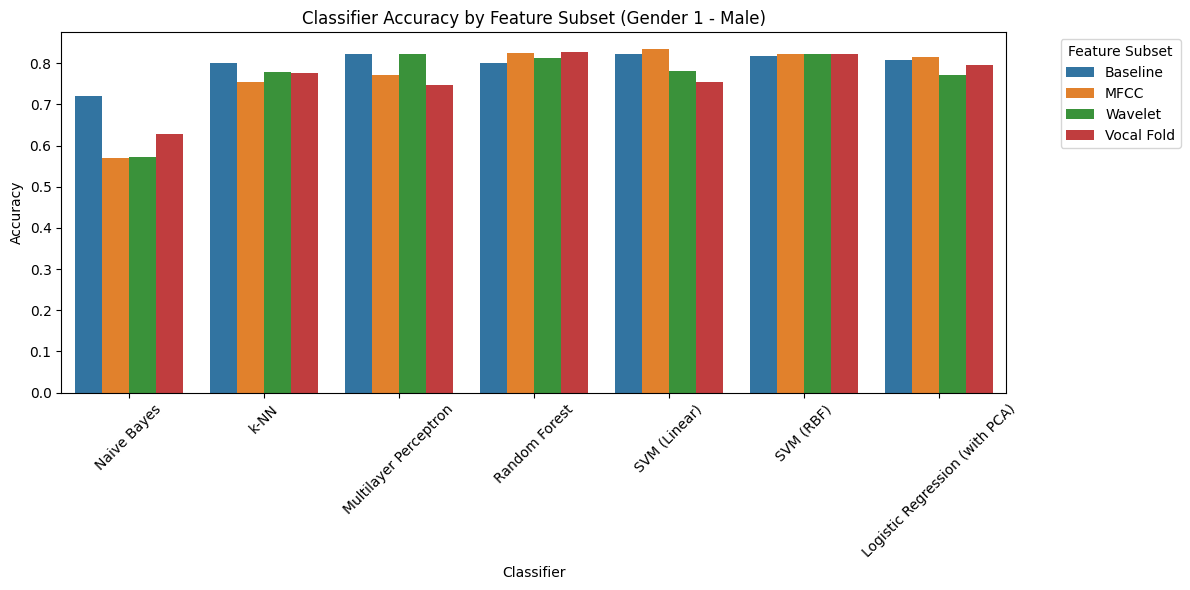

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter results for Gender 0 and Gender 1
gender_0 = results_df[results_df['Gender'] == 0]
gender_1 = results_df[results_df['Gender'] == 1]

# Plot function
def plot_performance(data, metric, title):
    plt.figure(figsize=(12, 6))
    sns.barplot(data=data, x='Classifier', y=metric, hue='Feature Subset')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.ylabel(metric)
    plt.xlabel('Classifier')
    plt.legend(title='Feature Subset', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Plot for Gender 0 and Gender 1
plot_performance(gender_0, 'Accuracy', 'Classifier Accuracy by Feature Subset (Gender 0 - Female)')
plot_performance(gender_1, 'Accuracy', 'Classifier Accuracy by Feature Subset (Gender 1 - Male)')


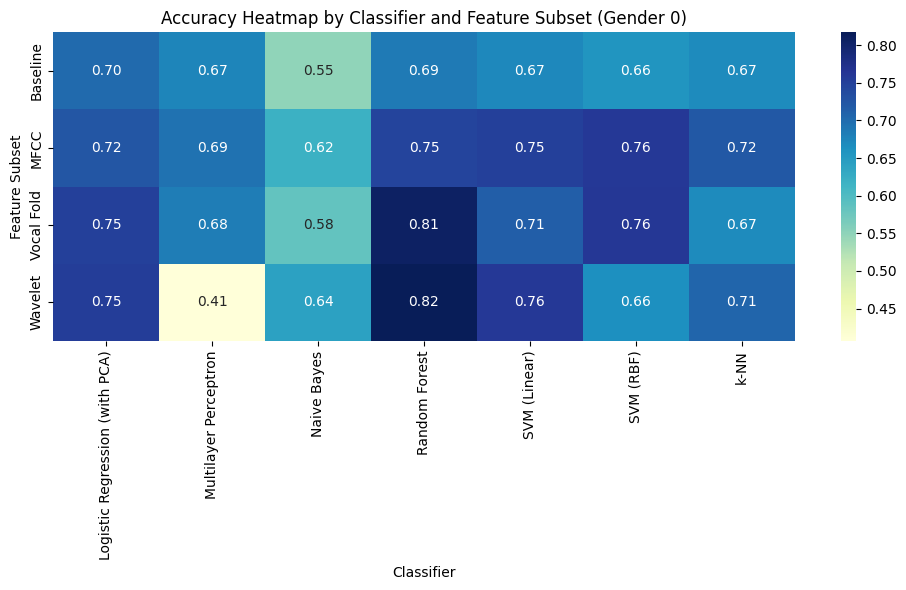

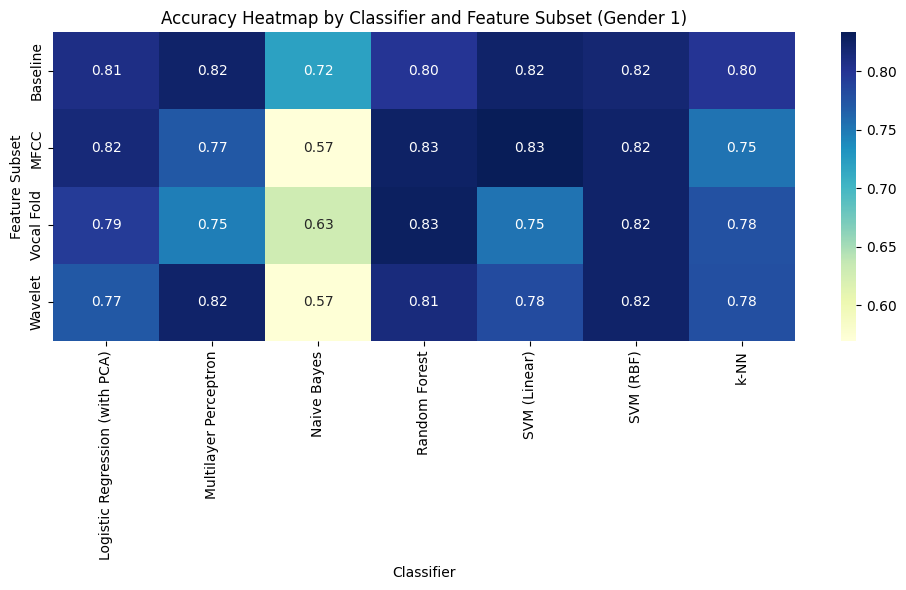

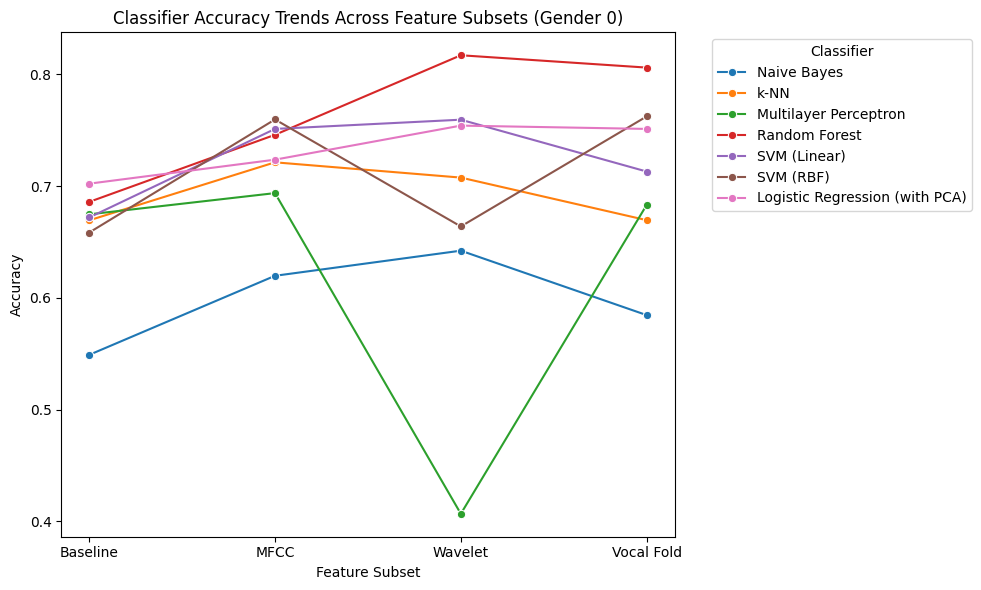

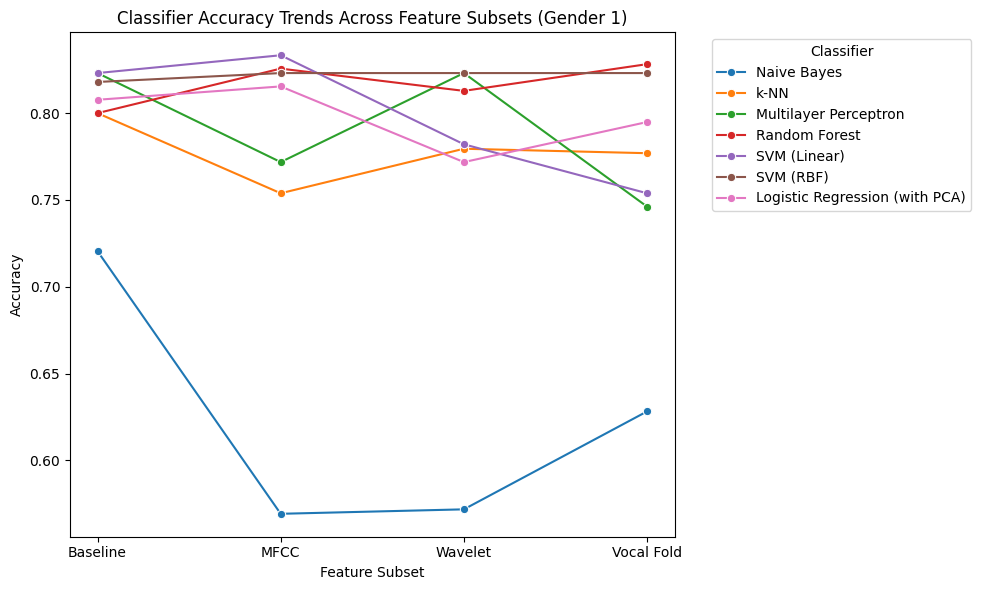

In [14]:
# Pivot data for heatmap
heatmap_data_0 = gender_0.pivot_table(index='Feature Subset', columns='Classifier', values='Accuracy')
heatmap_data_1 = gender_1.pivot_table(index='Feature Subset', columns='Classifier', values='Accuracy')

# Plot heatmap function
def plot_heatmap(data, title):
    plt.figure(figsize=(10, 6))
    sns.heatmap(data, annot=True, fmt=".2f", cmap="YlGnBu")
    plt.title(title)
    plt.xlabel('Classifier')
    plt.ylabel('Feature Subset')
    plt.tight_layout()
    plt.show()

# Heatmap for Gender 0 and Gender 1
plot_heatmap(heatmap_data_0, 'Accuracy Heatmap by Classifier and Feature Subset (Gender 0)')
plot_heatmap(heatmap_data_1, 'Accuracy Heatmap by Classifier and Feature Subset (Gender 1)')


# Line plot function
def plot_trends(data, metric, title):
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=data, x='Feature Subset', y=metric, hue='Classifier', marker='o')
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel('Feature Subset')
    plt.legend(title='Classifier', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Plot trends for Gender 0 and Gender 1
plot_trends(gender_0, 'Accuracy', 'Classifier Accuracy Trends Across Feature Subsets (Gender 0)')
plot_trends(gender_1, 'Accuracy', 'Classifier Accuracy Trends Across Feature Subsets (Gender 1)')
